In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score,precision_score,f1_score,log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier

In [2]:
train = pd.read_csv(r"C:\Users\elifa\Downloads\train.csv")
test  = pd.read_csv(r"C:\Users\elifa\Downloads\test.csv")
sample_submission= pd.read_csv(r"C:\Users\elifa\Downloads\sample_submission.csv")
train

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,1672,30,Travel_Rarely,945,Sales,1,3,Life Sciences,1,4,...,80,0,10,2,4,10,0,0,8,0
1673,1673,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,1,...,80,1,10,3,4,4,2,1,3,0
1674,1674,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,1,2,...,80,0,1,2,3,1,0,0,0,1
1675,1675,36,Travel_Rarely,441,Sales,9,2,Marketing,1,2,...,80,2,10,3,2,10,3,0,8,0


In [3]:
original_data = pd.read_csv(r"C:\Users\elifa\Downloads\WA_Fn-UseC_-HR-Employee-Attrition.csv")
# munging the original data to make it appear more like our train DataFrame
original_data = original_data.rename(columns={'EmployeeNumber': 'id'})
original_data['Attrition'] = (original_data['Attrition'] == 'Yes').astype(int)

# rearranging columns so that they are in the same order as in train
original_data = original_data[train.columns.tolist()]

# adding the source column
original_data['source'] = 'original'
train['source'] = 'synthetic'
test['source'] = 'synthetic'

# combining the datasets
train = pd.concat([train, original_data])
train.reset_index(inplace=True, drop=True)
#train.drop(columns=['EmployeeCount','Over18','StandardHours','PerformanceRating','id'],inplace=True)
#test.drop(columns=['EmployeeCount','Over18','StandardHours','PerformanceRating','id'],inplace=True)


In [34]:
train.groupby(["StockOptionLevel","MaritalStatus"]).size().unstack()


MaritalStatus,Divorced,Married,Single
StockOptionLevel,,,
0,11.0,305.0,1047.0
1,413.0,928.0,NaN
2,141.0,152.0,NaN
3,89.0,61.0,NaN


In [35]:
train["Attrition"].value_counts()

Attrition
0    2710
1     437
Name: count, dtype: int64

In [4]:
def feat_eng2(df):
    #df['MonthlyIncome/Age'] = df['MonthlyIncome'] / df['Age']

    #df["Age_risk"] = (df["Age"] < 34).astype(int)
    #df["HourlyRate_risk"] = (df["HourlyRate"] < 60).astype(int)
    df["Distance_risk"] = (df["DistanceFromHome"] >= 20).astype(int)
    df["YearsAtCo_risk"] = (df["YearsAtCompany"] < 4).astype(int)

    df['NumCompaniesWorked'] = df['NumCompaniesWorked'].replace(0, 1)
    #df['AverageTenure'] = df["TotalWorkingYears"] / df["NumCompaniesWorked"]
    # df['YearsAboveAvgTenure'] = df['YearsAtCompany'] - df['AverageTenure']

    #df['JobHopper'] = ((df["NumCompaniesWorked"] > 2) & (df["AverageTenure"] < 2.0)).astype(int)

    #df["AttritionRisk"] = df["Age_risk"] + df["HourlyRate_risk"] + df["Distance_risk"] + df["YearsAtCo_risk"] + df['JobHopper']
feat_eng2(train)
feat_eng2(test)
from sklearn.preprocessing import StandardScaler
def feat_eng(data):

    data['YearsAtCompanyWithCurrManager'] = data['YearsAtCompany'] * data['YearsWithCurrManager']
feat_eng(train)
feat_eng(test)


In [5]:
def dataanalysis(df):
    #df = df[~(df['TotalWorkingYears'] > 38)]  # Önceki toplam çalışma yılı koşulu
    #df = df[~(df['YearsAtCompany'] > 36)]    # Önceki şirkette geçen yıl koşulu
    df = df[~(df['DailyRate'] > 1499.00)]   # Günlük ücret koşulu: 1499.00'dan yüksek olanları filtrele
    #df.loc[df['JobLevel'] > 4,'JobLevel'] = 5  # İş seviyesi koşulu: İş seviyesi 4'ten büyük olanları 5'e ayarla
    return df

# 'train' ve 'test' veri çerçevelerine filtre uygula
train = dataanalysis(train)
test = dataanalysis(test)

                          Feature  Correlation
0                  YearsAtCo_risk     0.170812
1                StockOptionLevel     0.161036
2                             Age     0.156412
3               TotalWorkingYears     0.152527
4                        JobLevel     0.150856
5              YearsInCurrentRole     0.145665
6                   MonthlyIncome     0.141151
7            YearsWithCurrManager     0.140234
8                  JobInvolvement     0.137202
9                  YearsAtCompany     0.129250
10        EnvironmentSatisfaction     0.098406
11  YearsAtCompanyWithCurrManager     0.096813
12                JobSatisfaction     0.083519
13       RelationshipSatisfaction     0.067658
14                      Education     0.058574
15                WorkLifeBalance     0.055260
16               DistanceFromHome     0.053367
17                  Distance_risk     0.050346
18                      DailyRate     0.046185
19          TrainingTimesLastYear     0.038425
20           

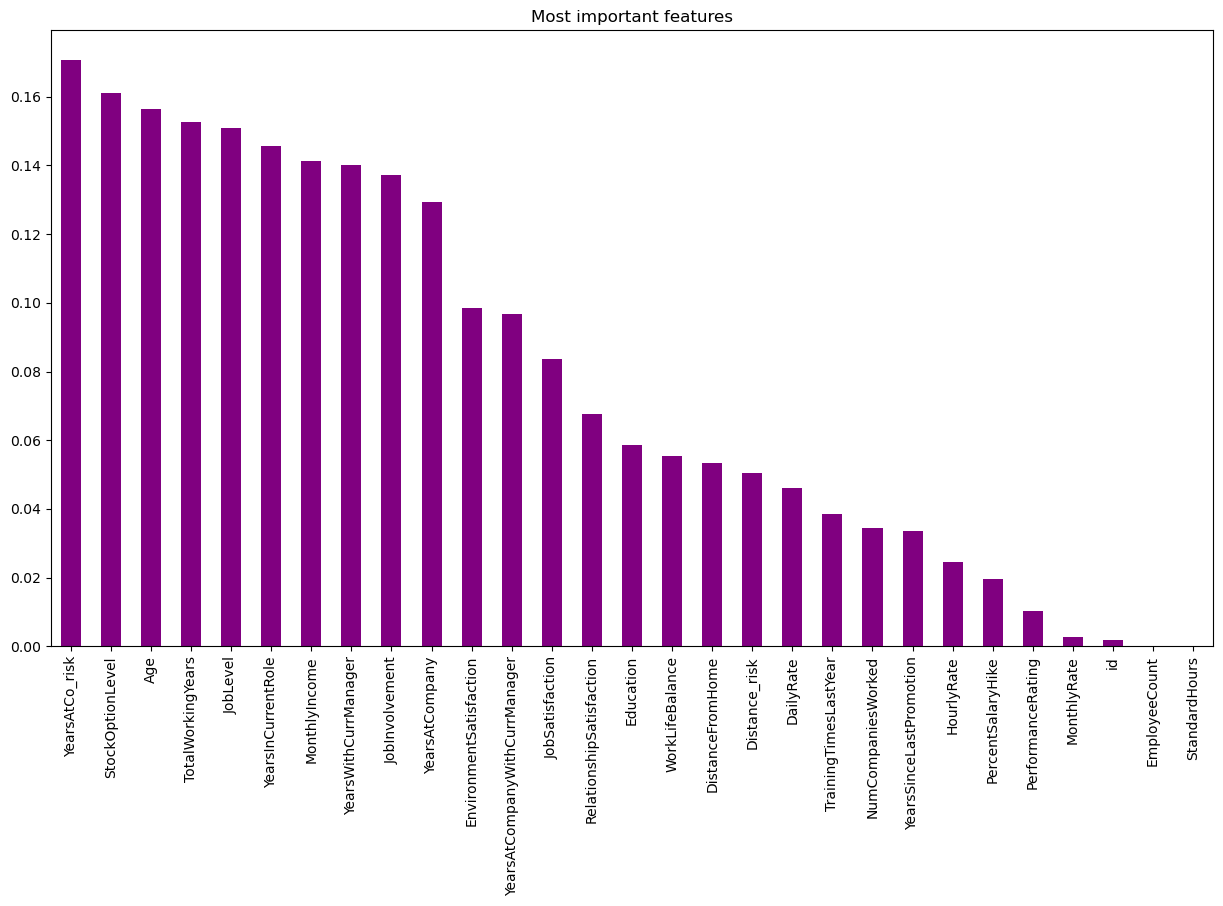

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Korelasyon matrisini oluşturun
numeric_columns = train.select_dtypes(include=np.number).columns
numeric_data = train[numeric_columns]
correlation_matrix = numeric_data.corr()

# 'Attrition' ile olan korelasyonu sıralayın
sorted_corr = correlation_matrix.drop('Attrition')['Attrition'].abs().sort_values(ascending=False)

# Sıralanmış korelasyonları içeren bir DataFrame oluşturun
result_df = pd.DataFrame({'Feature': sorted_corr.index, 'Correlation': sorted_corr.values})

# DataFrame'i görüntüleyin
print(result_df)

# Grafik oluşturun
plt.figure(figsize=(15, 8))
sorted_corr.plot(kind='bar', title='Most important features', color='purple')
plt.show()


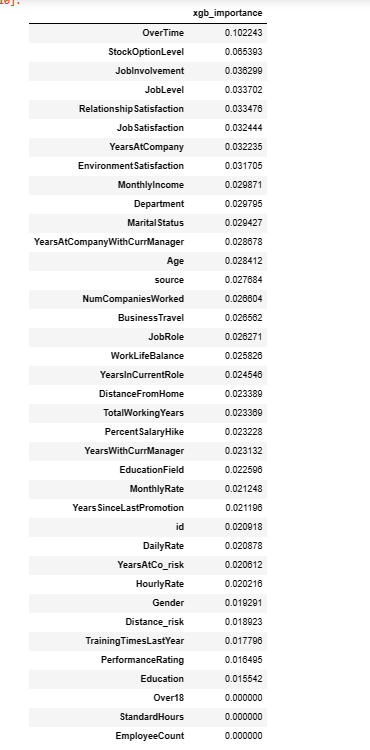

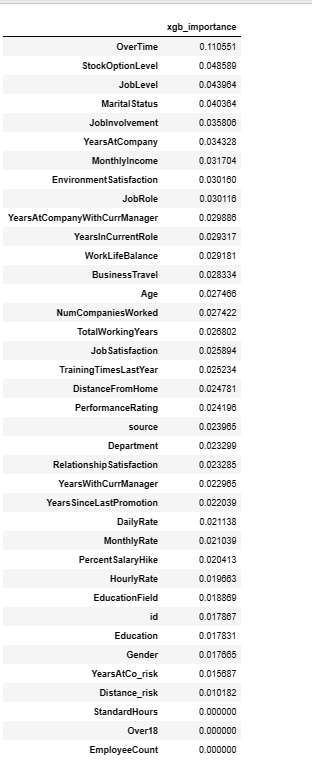

In [54]:
from IPython.display import Image, display

# Resmin dosya yolları
image_path = r"C:\Users\elifa\OneDrive\Resimler\Ekran Görüntüleri\Ekran görüntüsü 2023-11-30 001305.png"
image2_path = r"C:\Users\elifa\OneDrive\Resimler\Ekran Görüntüleri\Ekran görüntüsü 2023-11-30 221849.png"

# Resimleri yatay olarak göster
display(Image(filename=image_path), Image(filename=image2_path))


In [53]:
train["EmployeeCount"].value_counts()

EmployeeCount
1    1677
Name: count, dtype: int64

In [51]:
train["Over18"].value_counts()

Over18
Y    1677
Name: count, dtype: int64

In [52]:
train["StandardHours"].value_counts()

StandardHours
80    1677
Name: count, dtype: int64

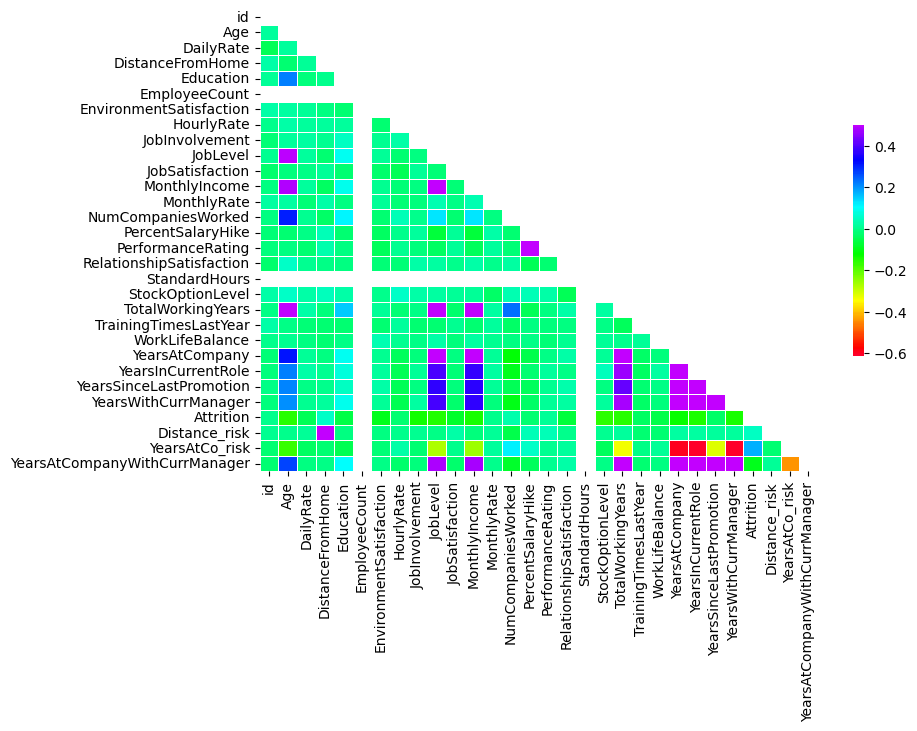

In [7]:
# Korelasyon matrisini görselleştir
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(correlation_matrix,  mask=mask, cmap='gist_rainbow', vmax=.5, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

# Label encoding uygulanacak sütunların listesi
columns_to_encode = train.select_dtypes(include='object').columns

# Her sütuna ait LabelEncoder nesnelerini saklamak için bir sözlük oluştur
label_encoders = {}

for column in columns_to_encode:
    # Yeni bir LabelEncoder nesnesi oluştur
    le = LabelEncoder()
    
    # Train setinde fit_transform uygula
    train[column] = le.fit_transform(train[column])

    # Test setinde transform uygula
    test[column] = le.transform(test[column])



In [9]:
xgb_params = {'n_estimators': 150,
                 'max_depth': 4,
                 'learning_rate': 0.1,
                 'min_child_weight': 4,
                 'subsample': 0.7,
                 'colsample_bytree': 0.3
              ,'random_state' : 42
             }


In [10]:
X = train.drop("Attrition", axis=1)
y = train["Attrition"]


model = XGBClassifier(**xgb_params)


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_scores = []
test_scores = []
predictions = []
# K-Fold cross-validation uygula
for train_index, test_index in kf.split(X,y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns,
                     data=model.feature_importances_,
                     columns=['xgb_importance'])
xgb_imp_feats = feats.sort_values("xgb_importance", ascending=False)
xgb_imp_feats

,xgb_importance
OverTime,0.110551
StockOptionLevel,0.048589
JobLevel,0.043964
MaritalStatus,0.040364
JobInvolvement,0.035806
YearsAtCompany,0.034328
MonthlyIncome,0.031704
EnvironmentSatisfaction,0.030160
JobRole,0.030116
YearsAtCompanyWithCurrManager,0.029886


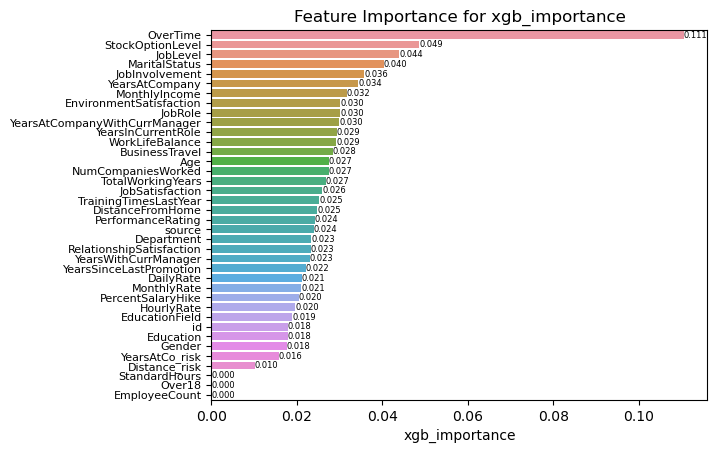

In [11]:
ax = sns.barplot(x=xgb_imp_feats["xgb_importance"], y=xgb_imp_feats.index)
ax.bar_label(ax.containers[0],fmt="%.3f", fontsize=6)
ax.tick_params(axis='y', labelsize=8)
plt.title("Feature Importance for xgb_importance")
plt.show()

In [12]:
selected_features = xgb_imp_feats[xgb_imp_feats.values > 0.018]
selected_features

,xgb_importance
OverTime,0.110551
StockOptionLevel,0.048589
JobLevel,0.043964
MaritalStatus,0.040364
JobInvolvement,0.035806
YearsAtCompany,0.034328
MonthlyIncome,0.031704
EnvironmentSatisfaction,0.030160
JobRole,0.030116
YearsAtCompanyWithCurrManager,0.029886


In [13]:
X = X[selected_features.index]
X

,OverTime,StockOptionLevel,JobLevel,MaritalStatus,JobInvolvement,YearsAtCompany,MonthlyIncome,EnvironmentSatisfaction,JobRole,YearsAtCompanyWithCurrManager,...,source,Department,RelationshipSatisfaction,YearsWithCurrManager,YearsSinceLastPromotion,DailyRate,MonthlyRate,PercentSalaryHike,HourlyRate,EducationField
0,1,1,1,1,3,10,2596,4,2,80,...,1,1,2,8,7,599,5099,13,42,3
1,0,1,1,1,3,4,2899,1,8,12,...,1,2,4,3,0,921,10778,17,46,4
2,0,2,2,0,3,3,4627,3,7,6,...,1,2,4,2,1,718,16495,17,80,2
3,0,0,2,1,3,6,5347,3,0,12,...,1,1,3,2,0,1488,13384,14,40,3
4,1,0,5,2,3,31,19033,2,3,310,...,1,1,3,10,4,1017,19805,13,37,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,0,1,2,1,4,5,2571,3,2,15,...,0,1,3,3,0,884,12290,17,41,3
3143,0,1,3,1,2,7,9991,4,0,49,...,0,1,1,7,1,613,21457,15,42,3
3144,1,1,2,1,4,6,6142,2,4,18,...,0,1,2,3,0,155,5174,20,87,1
3145,0,0,2,1,2,9,5390,4,7,72,...,0,2,4,8,0,1023,13243,14,63,3


In [14]:
test=test[selected_features.index]
test

,OverTime,StockOptionLevel,JobLevel,MaritalStatus,JobInvolvement,YearsAtCompany,MonthlyIncome,EnvironmentSatisfaction,JobRole,YearsAtCompanyWithCurrManager,...,source,Department,RelationshipSatisfaction,YearsWithCurrManager,YearsSinceLastPromotion,DailyRate,MonthlyRate,PercentSalaryHike,HourlyRate,EducationField
0,0,0,1,2,3,1,2318,4,2,0,...,1,1,4,0,0,992,17778,12,43,3
1,1,1,2,0,3,2,5486,3,7,4,...,1,2,3,2,2,1136,12421,12,67,2
2,1,2,1,0,3,7,2741,4,6,49,...,1,1,2,7,1,155,23577,13,41,1
3,0,0,2,2,2,14,5228,3,0,112,...,1,1,3,8,11,688,20364,13,89,1
4,0,0,1,2,3,1,1223,3,2,0,...,1,1,1,0,0,464,15178,14,79,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114,0,1,1,0,2,1,4678,3,8,0,...,1,2,3,0,0,755,9150,12,81,1
1115,0,1,2,1,2,20,6220,3,2,160,...,1,1,4,8,1,654,6409,14,96,3
1116,0,1,2,1,3,5,5238,2,0,10,...,1,1,1,2,0,884,6069,17,65,3
1117,0,1,2,1,2,4,4799,3,7,12,...,1,2,4,3,1,1469,17519,11,68,5


In [15]:
X 
y = train["Attrition"]

model = BaggingClassifier(base_estimator=XGBClassifier(**xgb_params),
                         
                                  n_estimators=10, random_state=42)  

# K-Fold cross-validation ayarları
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_scores = []
test_scores = []
predictions = []
# K-Fold cross-validation uygula
for train_index, test_index in kf.split(X,y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Modeli eğit
    model.fit(X_train, y_train)

    # Eğitim ve test skorlarını hesapla
    train_preds = model.predict_proba(X_train)[:, 1]
    test_preds = model.predict_proba(X_test)[:, 1]
    res_preds = model.predict_proba(test)[:, 1]
    
    train_auc = roc_auc_score(y_train, train_preds)
    test_auc = roc_auc_score(y_test, test_preds)

    train_scores.append(train_auc)
    test_scores.append(test_auc)
    predictions.append(res_preds)
    print(f"Eğitim Skoru: {train_auc:.2f}, Test Skoru: {test_auc:.2f}")
    
# Ortalama eğitim ve test skorlarını yazdır
print(f"\nOrtalama Eğitim Skoru: {np.mean(train_scores):.3f}")
print(f"Ortalama Test Skoru: {np.mean(test_scores):.3f}")
pred_res = pd.DataFrame(np.mean(predictions,axis=0),columns=['preds'])
np.round(pd.DataFrame(np.mean(predictions,axis=0),columns=['preds'])).astype(int)['preds'].value_counts()
sample_submission['Attrition'] = pred_res['preds'].values
sample_submission.to_csv('feature_importance30.csv',index=False)

Eğitim Skoru: 0.98, Test Skoru: 0.86
Eğitim Skoru: 0.98, Test Skoru: 0.90
Eğitim Skoru: 0.98, Test Skoru: 0.86
Eğitim Skoru: 0.98, Test Skoru: 0.90
Eğitim Skoru: 0.98, Test Skoru: 0.84
Eğitim Skoru: 0.98, Test Skoru: 0.88
Eğitim Skoru: 0.98, Test Skoru: 0.84
Eğitim Skoru: 0.98, Test Skoru: 0.80
Eğitim Skoru: 0.98, Test Skoru: 0.83
Eğitim Skoru: 0.98, Test Skoru: 0.82

Ortalama Eğitim Skoru: 0.979
Ortalama Test Skoru: 0.854


In [16]:
pred_res = pd.DataFrame(np.mean(predictions,axis=0),columns=['preds'])
np.round(pd.DataFrame(np.mean(predictions,axis=0),columns=['preds'])).astype(int)['preds'].value_counts()

preds
0    1051
1      68
Name: count, dtype: int64

In [ ]:
9 sutun varken 
Ortalama Eğitim Skoru: 0.886
Ortalama Test Skoru: 0.822

preds
0    1052
1      67
Name: count, dtype: int64    

    
20 sutun varken     
    
    preds
0    1035
1      84
Name: count, dtype: int64    
        
        

In [90]:
print(np.__version__)

1.24.3


In [89]:
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Modeli ve veriyi kullanarak SHAP explainer oluşturun
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP değerlerini görselleştirin
shap.summary_plot(shap_values, max_display=300, feature_names=features, plot_size=(20, 100))


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations